In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import os
os.chdir('C:/Users/Abhishek/Desktop/Case Studies/AI ML/Quora Question Pair')

In [41]:
#Read 
data = pd.read_csv('train.csv')
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [42]:
data.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [44]:
# Very Few Missing Columns so we can just Delete
data.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [45]:
data=data.dropna(axis=0,how='any')

In [46]:
data.shape

(404287, 6)

# EDA

In [47]:
# Counts for our Target i.e 0=Not- Duplicate , 1=Duplicate
data["is_duplicate"].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

Text(0, 0.5, 'Count')

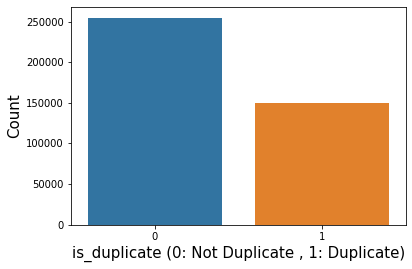

In [48]:
sns.countplot(data=data,x="is_duplicate")
plt.xlabel("is_duplicate (0: Not Duplicate , 1: Duplicate)",size=15,color="Black")
plt.ylabel("Count",size=15,color="Black")

In [49]:
#Total number of question pairs for training
print("The total Number of pairs are :{}".format(len(data)))

The total Number of pairs are :404287


In [50]:
# Check % of Distribution of is_duplicate {0,1}

print("The % of Unsimilar pairs :",round(len(data[data["is_duplicate"]==0])/len(data)*100,2))
print("The % of Duplicate pairs :",round(len(data[data["is_duplicate"]==1])/len(data)*100,2))

The % of Unsimilar pairs : 63.08
The % of Duplicate pairs : 36.92


In [51]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

<h3> Number of unique questions </h3>

In [52]:
totalQid = data.qid1.append(data.qid2)
uniqueQ=len(totalQid.unique())
print("Total Question id are :",len(totalQid))
print("Unique Questions are  :",uniqueQ)

# Questions that Occur more than once
morethanonceQid = sum(totalQid.value_counts() > 1)
print('Questions that Occur more than once {} ({}): '.format(morethanonceQid ,morethanonceQid/len(totalQid.unique())*100))

Total Question id are : 808574
Unique Questions are  : 537929
Questions that Occur more than once 111778 (20.779322178205675): 


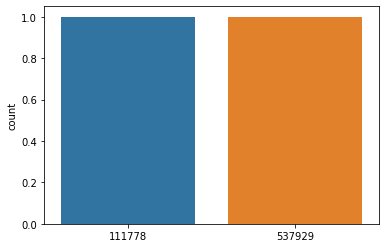

In [53]:
x=[uniqueQ,morethanonceQid] 
sns.countplot(x)
#plt.ylim(0,1)
plt.show()


#y=[uniqueQ,morethanonceQid] 
#x=["uniqueQ","morethanonceQid"] 
#sns.barplot(x,y)

<h3>Checking for Duplicates </h3>

In [54]:
pair_duplicates = data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - data.shape[0])

Number of duplicate questions 0


<h3> Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



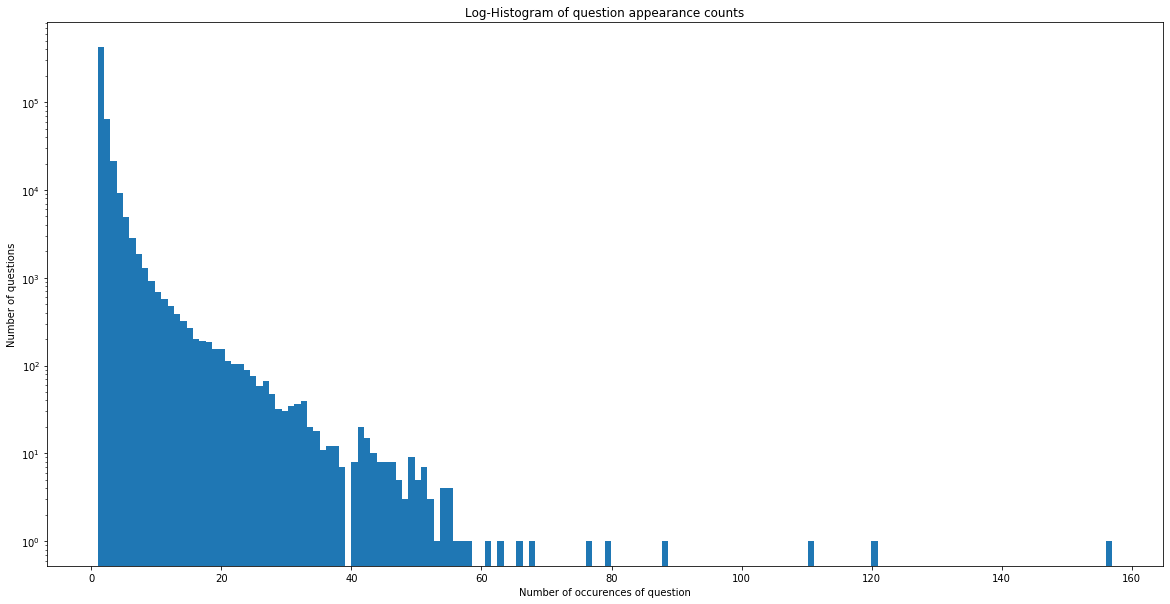

In [55]:
plt.figure(figsize=(20, 10))


plt.hist(totalQid.value_counts(),bins=160)
plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(totalQid.value_counts()))) 

3.2.5 Checking for NULL values

In [56]:
#Checking whether there are any rows with null values
data.isna().sum()

# Filling the null values with ' ' if There are missing values

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

<h2>Basic Feature Extraction (before cleaning) </h2>

- https://www.youtube.com/watch?v=txMdrV1Ut64

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

# Creating the Above features :

## 1.df['word_Common']
- 1.**map()** :**The map() function executes a specified function for each item in a iterable. The item is sent to the function as a parameter.**
-  Here 1.lambda word: word.lower().strip() is the function.
-  ____ 2.row['question1'].split(" ") is the iterable object
-  It will take words one by one from "question1",apply the function to it and place in set()


- 2.**Set** : Build an unordered collection of **unique elements** (Will take the whole data and keep only unique elements)

In [63]:
data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3


In [58]:
data["freq_qid1"]=data.groupby(['qid1'])['qid1'].transform('count')  #.count() is also working similarrly but not sure so use transform('count')
data["freq_qid2"]=data.groupby(['qid2'])['qid2'].transform('count')
data['q1len']=data["question1"].apply(lambda x : len(x))
data['q2len']=data["question2"].apply(lambda x : len(x))
data['q1_n_words']=data["question1"].apply(lambda x : len(str(x).split()))
data['q2_n_words']=data["question2"].apply(lambda x : len(str(x).split()))

def common_word(row):
    w1=set(map(lambda x : x.lower().strip(),row["question1"].split(" ")))  # Set of all words in W1
    w2=set(map(lambda x : x.lower().strip(),row["question2"].split(" ")))  # Set of all words in W2
    return len(w1&w2) #Words Present in both W1 and W2
data['word_Common']=data.apply(common_word,axis=1)

def tot_words(row):
    w1=set(map(lambda x : x.strip(),row["question1"].split(" "))) #Strip :Return a copy of the string with leading and trailing whitespace removed.
    w2=set(map(lambda x : x.strip(),row["question2"].split(" ")))
    return len(w1) + len(w2) #Words Present in both W1 and W2
data['word_Total']=data.apply(tot_words,axis=1)

data['word_share'] =data['word_Common']/data['word_Total']
data['freq_q1+q2'] = data['freq_qid1']+data['freq_qid2']
data['freq_q1-q2'] = abs(data['freq_qid1']-data['freq_qid2']) #Absolute Value

<h3> Analysis of some of the extracted features </h3>

In [59]:
print("Minimum length of the questions in question1 :",data['q1_n_words'].min())
print("Minimum length of the questions in question2 :",data['q2_n_words'].min())

print("Minimum length of the questions in question2 :",len(data[data['q1_n_words']==1]))
print("Minimum length of the questions in question2 :",len(data[data['q2_n_words']==1]))

Minimum length of the questions in question1 : 1
Minimum length of the questions in question2 : 1
Minimum length of the questions in question2 : 69
Minimum length of the questions in question2 : 25


In [60]:
#All our fetures are int ,except word_share which is float
data.dtypes

id                int64
qid1              int64
qid2              int64
question1        object
question2        object
is_duplicate      int64
freq_qid1         int64
freq_qid2         int64
q1len             int64
q2len             int64
q1_n_words        int64
q2_n_words        int64
word_Common       int64
word_Total        int64
word_share      float64
freq_q1+q2        int64
freq_q1-q2        int64
dtype: object

In [61]:
data.corr().sort_values(by='is_duplicate')

#word_share, freq_qid1, freq_q1+q2, freq_qid2,word_Common Have Good Correlation with is_duplicate.

,id,qid1,qid2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
qid2,0.641991,0.700138,1.000000,-0.260101,-0.310959,-0.345283,0.050033,0.065485,0.041770,0.062816,-0.084591,0.061106,-0.112423,-0.382395,-0.271850
qid1,0.629371,1.000000,0.700138,-0.247070,-0.383712,-0.235650,0.054504,0.026775,0.043638,0.023783,-0.088044,0.037296,-0.107183,-0.345626,-0.211861
word_Total,0.003001,0.037296,0.061106,-0.183282,-0.013652,-0.022998,0.807504,0.842835,0.833072,0.862375,0.380730,1.000000,-0.190854,-0.021986,-0.005527
q1len,0.003906,0.054504,0.050033,-0.171088,-0.031983,-0.015637,1.000000,0.484578,0.958020,0.458723,0.312427,0.807504,-0.166113,-0.026154,-0.008636
q2len,0.001610,0.026775,0.065485,-0.161974,-0.010355,-0.033177,0.484578,1.000000,0.461798,0.967561,0.311281,0.842835,-0.158593,-0.027106,-0.011979
q2_n_words,0.001119,0.023783,0.062816,-0.160407,-0.009076,-0.034773,0.458723,0.967561,0.471456,1.000000,0.309604,0.862375,-0.164373,-0.027533,-0.013625
q1_n_words,0.003545,0.043638,0.041770,-0.154253,-0.020947,-0.008094,0.958020,0.461798,1.000000,0.471456,0.328506,0.833072,-0.158117,-0.015705,-0.000215
id,1.000000,0.629371,0.641991,-0.008783,-0.002686,-0.001308,0.003906,0.001610,0.003545,0.001119,-0.000012,0.003001,-0.002264,-0.002192,0.000253
freq_q1-q2,0.000253,-0.211861,-0.271850,0.127097,0.438490,0.827815,-0.008636,-0.011979,-0.000215,-0.013625,0.048731,-0.005527,0.031486,0.765237,1.000000
word_Common,-0.000012,-0.088044,-0.084591,0.232283,0.098955,0.068581,0.312427,0.311281,0.328506,0.309604,1.000000,0.380730,0.771669,0.094311,0.048731


# Visualise

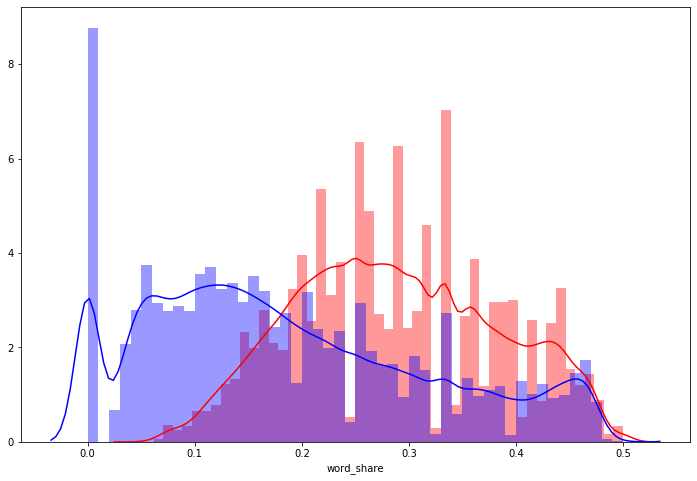

In [65]:
plt.figure(figsize=(12, 8))

sns.distplot(data[data['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

#- The distributions for word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
#- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

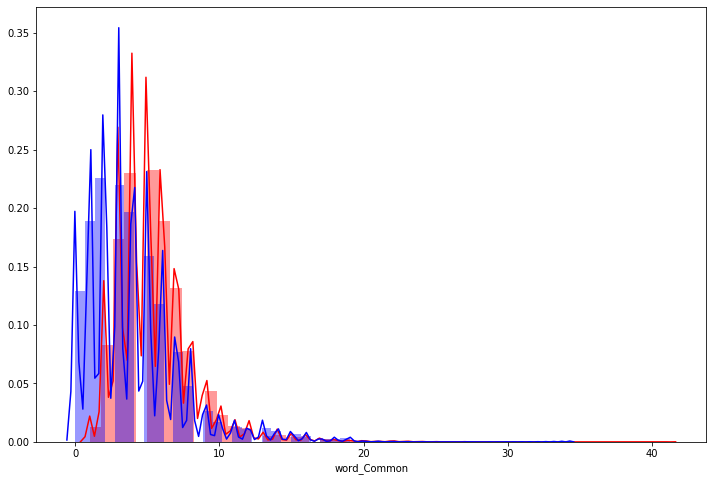

In [67]:
plt.figure(figsize=(12, 8))

sns.distplot(data[data['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()


#Highly Overlapping , no real conclusion here

## Save this Excel to use in step2